<a href="https://colab.research.google.com/github/mehrotrasan16/CS581-CAN-DO-Project/blob/tcn-baseline/code/TCN_CAN_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from numpy import load
import os
from sklearn.metrics import recall_score,f1_score
from imblearn.over_sampling import SMOTE

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Datasets

In [3]:
freedf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Attack_free_dataset.csv')
freedf['label'] = 0
freedf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0.000000,790,0,8,5,32,234,10,32,26,0,127,1
1,0.000224,809,0,8,215,167,127,140,17,47,0,16,1
2,0.000462,128,0,8,0,23,234,10,32,26,32,67,1
3,0.000704,129,0,8,127,132,96,0,0,0,0,83,1
4,0.000878,288,0,4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2369393,1037.589395,68,0,8,0,0,0,255,111,0,0,0,1
2369394,1037.589628,357,0,8,17,232,127,0,0,0,12,138,1
2369395,1037.589812,688,0,5,35,0,0,7,172,0,0,0,1
2369396,1037.590065,1200,0,8,0,0,0,0,0,0,0,0,1


In [4]:
freedf.groupby('label').count()

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,,
1,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398,2369398


In [5]:
dosdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/DoS_attack_dataset.csv')
dosdf['label'] = np.where(dosdf['CAN ID'] == 0,1,0) #np.where(df['Set']=='Z', 'green', 'red')
dosdf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0.000000,0,0,8,0,0,0,0,0,0,0,0,2
1,0.000271,128,0,8,0,23,220,9,22,17,22,187,1
2,0.000495,0,0,8,0,0,0,0,0,0,0,0,2
3,0.000736,129,0,8,64,132,135,0,0,0,0,107,1
4,0.000983,0,0,8,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
656574,306.295869,0,0,8,0,0,0,0,0,0,0,0,2
656575,306.296118,129,0,8,64,132,137,0,0,0,0,240,1
656576,306.296365,0,0,8,0,0,0,0,0,0,0,0,2
656577,306.296624,399,0,8,0,59,24,0,0,63,0,0,1


In [6]:
dosdf.groupby('label').count()

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,,
1,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955,320955
2,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624


In [7]:
fuzzydf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Fuzzy_attack_dataset.csv')
fuzzydf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
0,0.000000,544,0,8,41,197,38,85,106,103,2,93
1,0.000868,1201,0,8,94,81,207,183,76,153,170,151
2,0.001212,688,0,5,58,255,0,7,44,0,0,0
3,0.001452,357,0,8,0,8,128,2,0,0,12,134
4,0.001782,544,0,8,212,166,227,169,35,170,211,31
...,...,...,...,...,...,...,...,...,...,...,...,...
591985,347.330224,339,0,8,0,161,32,255,0,255,32,223
591986,347.330461,544,0,8,192,3,245,3,12,0,71,16
591987,347.330678,1440,0,8,166,32,82,109,167,238,124,226
591988,347.331050,1442,0,8,238,34,248,11,91,131,153,171


In [28]:
impersonatedf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Impersonation_attack_dataset.csv')
impersonatedf['label'] = np.where(impersonatedf['CAN ID'] == 356,1,0) 
impersonatedf

,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,1.481193e+09,1415,0,8,0,0,0,0,0,0,0,1,0
1,1.481193e+09,790,0,8,5,28,106,10,28,19,0,127,0
2,1.481193e+09,399,0,8,0,33,28,0,0,67,0,0,0
3,1.481193e+09,608,0,8,5,28,0,48,255,147,99,53,0
4,1.481193e+09,128,0,8,0,23,106,10,28,19,28,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995467,1.481193e+09,1508,0,3,0,2,0,0,0,0,0,0,0
995468,1.481193e+09,339,0,8,0,128,16,255,0,255,160,46,0
995469,1.481193e+09,357,0,8,14,216,127,0,0,0,3,170,0
995470,1.481193e+09,544,0,8,244,3,247,3,12,0,58,16,0


In [29]:
print(int('0x164',base=16))
impersonatedf.groupby('label').count()

356


,Timestamp,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,,
0,938000,938000,938000,938000,938000,938000,938000,938000,938000,938000,938000,938000
1,57472,57472,57472,57472,57472,57472,57472,57472,57472,57472,57472,57472


IN the above datasets, we have also added labels where possible, to try a supervised learning experiment.

### Combining Attack-free + DoS datasets 
 Here we work with the Attack-Free and DoS Datasets to get one less biased and slightly better distributed dataset to train and test on.

In [44]:
dosdf = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/DoS_attack_dataset.csv')
dosdf['label'] = np.where(dosdf['CAN ID'] == 0,1,0)
dosdf = dosdf.drop(labels=['Timestamp'],axis=1)
dosdf

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,0,0,8,0,0,0,0,0,0,0,0,1
1,128,0,8,0,23,220,9,22,17,22,187,0
2,0,0,8,0,0,0,0,0,0,0,0,1
3,129,0,8,64,132,135,0,0,0,0,107,0
4,0,0,8,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
656574,0,0,8,0,0,0,0,0,0,0,0,1
656575,129,0,8,64,132,137,0,0,0,0,240,0
656576,0,0,8,0,0,0,0,0,0,0,0,1
656577,399,0,8,0,59,24,0,0,63,0,0,0


In [45]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CS581/project-data/Attack_free_dataset.csv')
df['label'] = 0
df = df.drop(columns=['Timestamp'])
df

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,790,0,8,5,32,234,10,32,26,0,127,0
1,809,0,8,215,167,127,140,17,47,0,16,0
2,128,0,8,0,23,234,10,32,26,32,67,0
3,129,0,8,127,132,96,0,0,0,0,83,0
4,288,0,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2369393,68,0,8,0,0,0,255,111,0,0,0,0
2369394,357,0,8,17,232,127,0,0,0,12,138,0
2369395,688,0,5,35,0,0,7,172,0,0,0,0
2369396,1200,0,8,0,0,0,0,0,0,0,0,0


* Here we toss out the timestamp column as in this approach it is not informative about the nature of the outlier.
* It also helps us balance out the problems encountered in the previous attack-free and Dos attack experiments.

* in the attack free dataset - all the packets were normal data and so had to be labelled with only one value, training a model on single class data does not means it learns anything.

* in the Dos Attack experiment, every second message is a dos attack message, leaving the dataset evenly split 50:50 on anomalies/normal network data, but there is not enough contiguous network data for it to learn normal state nor attack state, and as a result it's accuracy is averaging around 50%

In [46]:
newdf = df.append(dosdf)
newdf

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,790,0,8,5,32,234,10,32,26,0,127,0
1,809,0,8,215,167,127,140,17,47,0,16,0
2,128,0,8,0,23,234,10,32,26,32,67,0
3,129,0,8,127,132,96,0,0,0,0,83,0
4,288,0,4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
656574,0,0,8,0,0,0,0,0,0,0,0,1
656575,129,0,8,64,132,137,0,0,0,0,240,0
656576,0,0,8,0,0,0,0,0,0,0,0,1
656577,399,0,8,0,59,24,0,0,63,0,0,0


In [47]:
newdf.groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353,2690353
1,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624,335624


In [48]:
335624/2690353

0.1247509155861703

# Installing and testing TCNs: Exploring applications

In [57]:
!pip install keras-tcn

In [11]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

from tcn import TCN, tcn_full_summary

batch_size, timesteps, input_dim = None, 20, 1

In [12]:
def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train

In [13]:
i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False)(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

tcn_full_summary(m, expand_residual_blocks=True)

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 20, 64)            128       
_________________________________________________________________
activation_2 (Activation)    (None, 20, 64)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 20, 64)            192       
_________________________________________________________________
activation (Activation)      (None, 20, 64)            0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 64)            0         
_________________________________________________________________
conv1D_1 (Conv1D)            (None, 20, 64)           

# Modifying this for our data and modifying our data for this TCN

# Baseline TCN

TCNs do not require the 3D input that LSTMs do, the Conv1D layers throw errors when we tried with the same input as the LSTMS, so we change our input data shape to work similar to the example referred to above.

In [118]:
batch_size, timesteps, input_dim = None, 11, 1

In [125]:
# # my x y training/testing data
# series = dosdf.to_numpy()

# n_rows = series.shape[0]
# n_features = series.shape[1]

# train_split = int(series.shape[0]*0.7)
# val_split = int(series.shape[0]*0.8)
# print(f'train split : {train_split}, val_split: {val_split}')

# X_train, y_train = series[:train_split, :n_features-1], series[:train_split, -1] # -1 references the last column
# X_valid, y_valid = series[train_split:val_split, :n_features-1], series[train_split:val_split, -1]
# X_test, y_test = series[val_split:, :n_features-1], series[val_split:, -1]

# print(f'{X_train.shape,y_train.shape,X_valid.shape, y_valid.shape, X_test.shape,y_test.shape}')

In [126]:
# X_test[20].shape, y_test[20].shape

In [127]:
# tempx, tempy = get_x_y()
# tempx[0].shape, tempy[0].shape

### Train-test-split



In [128]:
#Shuffle the dataset
newdf=newdf.sample(frac=1,random_state=200) #random state is a seed value 200 

series = newdf.to_numpy()
# print(series.shape)

n_features = series.shape[1]
train_split = int(series.shape[0]*0.7)
print(f'train split : {train_split}')

val_split = int(series.shape[0]*0.8)

X_train, y_train = series[:train_split, :n_features-1], series[:train_split, -1] # -1 references the last column
X_valid, y_valid = series[train_split:val_split, :n_features-1], series[train_split:val_split, -1]
X_test, y_test = series[val_split:, :n_features-1], series[val_split:, -1]
print(f'{X_train.shape,y_train.shape,X_valid.shape, y_valid.shape, X_test.shape,y_test.shape}')

train split : 2118183
((2118183, 11), (2118183,), (302598, 11), (302598,), (605196, 11), (605196,))


In [129]:
#X_train stats
newdf[:train_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,1882701,1882701,1882701,1882701,1882701,1882701,1882701,1882701,1882701,1882701,1882701
1,235482,235482,235482,235482,235482,235482,235482,235482,235482,235482,235482


In [130]:
#X_valid split
newdf[train_split:val_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,269141,269141,269141,269141,269141,269141,269141,269141,269141,269141,269141
1,33457,33457,33457,33457,33457,33457,33457,33457,33457,33457,33457


In [131]:
#X_test
newdf[val_split:].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,538511,538511,538511,538511,538511,538511,538511,538511,538511,538511,538511
1,66685,66685,66685,66685,66685,66685,66685,66685,66685,66685,66685


In [132]:
1 - (66685/538511)

0.876167803443198

In [143]:
testdf = pd.Series(y_test)
testdf.value_counts()

0    538511
1     66685
dtype: int64

### Baseline TCN Model

In [188]:
tf.keras.backend.clear_session()

In [189]:
i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        nb_filters=64,
        kernel_size=2,
        nb_stacks=1,
        padding='same',
        use_skip_connections=False,
        dropout_rate=0.0,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=True)(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam',
          loss='mse',
          metrics=['accuracy'])

tcn_full_summary(m, expand_residual_blocks=True)

early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = m.fit(X_train, y_train,
      validation_data=(X_valid,y_valid),
      epochs=5,
      batch_size=128,
      callbacks=[early_stop])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 11, 64)            128       
_________________________________________________________________
activation_2 (Activation)    (None, 11, 64)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 11, 64)            192       
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 11, 64)            0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 11, 64)           

KeyboardInterrupt: ignored

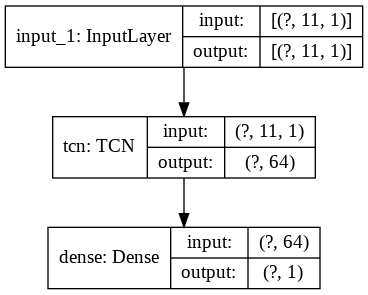

In [190]:
tf.keras.utils.plot_model(m,show_shapes=True)

### Evaluation and Plotting

In [257]:
scores = m.evaluate(X_test,y_test)
print(f"Loss, Accuracy: {scores}")

2365/2365 [==============================] - 9s 4ms/step - loss: 0.0402 - accuracy: 0.9391
Loss, Accuracy: [0.040159717202186584, 0.9391205310821533]


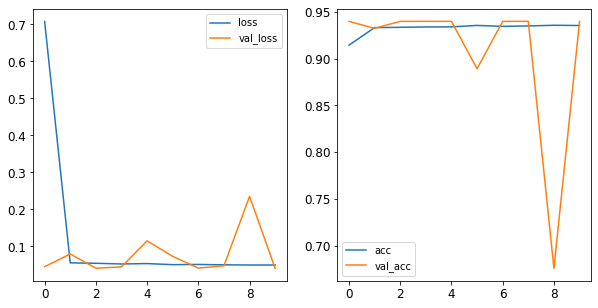

In [192]:
plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(('acc','val_acc'))

plt.gcf().set_size_inches((10,5))
plt.show()

In [193]:
y_pred = m.predict(X_test, )

In [194]:
X_test[30],y_test[30], np.argmax(y_pred[30])

(array([880,   0,   8, 255,  32,   0, 128, 255,   0,   0, 100]), 0, 0)

In [195]:
classes = np.array([np.argmax(i) for i in y_pred])
np.unique(classes), classes[:20]

(array([0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [196]:
recall_score(y_test,classes)

0.0

In [197]:
predlist = classes.reshape((classes.shape[0],1))
y_test.shape, y_pred.shape, predlist.shape

((605196,), (605196, 1), (605196, 1))

In [198]:
compdf = pd.DataFrame(predlist)
compdf['real'] = y_test
compdf = compdf.rename(columns={0:'pred'})
compdf['T/F Prediction'] = np.where(compdf['pred'] == compdf['real'],True, False)
compdf

,pred,real,T/F Prediction
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,0,0,True
...,...,...,...
605191,0,0,True
605192,0,0,True
605193,0,0,True
605194,0,0,True


In [199]:
np.unique(compdf.loc[compdf.real == 1]['T/F Prediction'])

array([False])

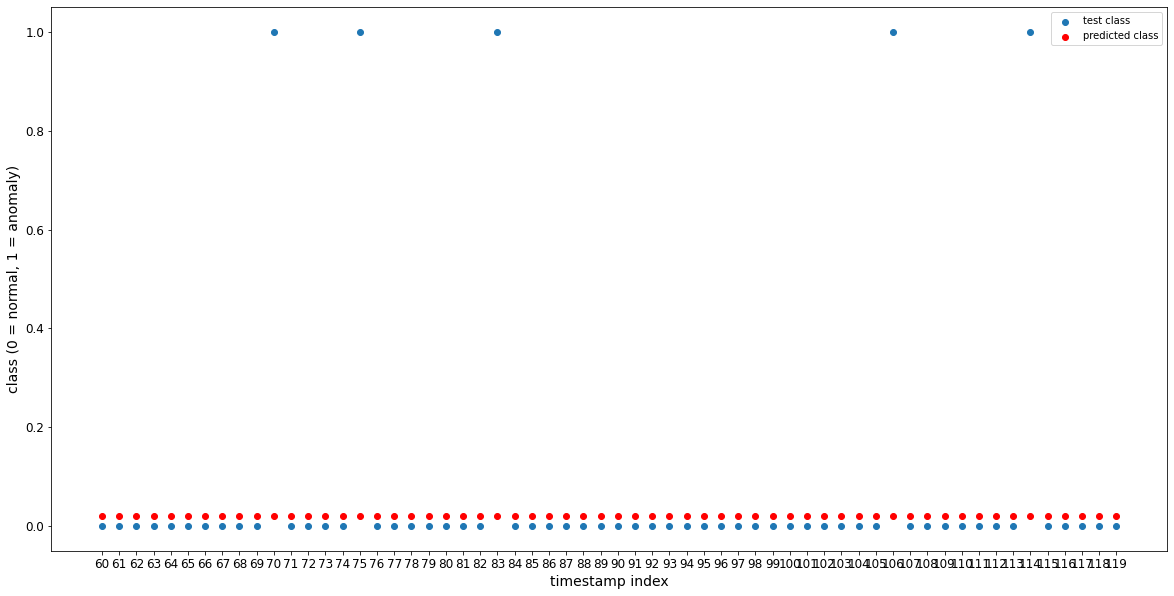

In [200]:
plot_min=60
plot_max =120
plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.02 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
plt.legend(('test class','predicted class'))
plt.xlabel('timestamp index')
plt.ylabel('class (0 = normal, 1 = anomaly)')
plt.xticks(ticks=range(plot_min, plot_max))
plt.gcf().set_size_inches((20,10))
# plt.gcf().autofmt_xdate()
plt.show()

### Saving and Checking the size of the Model

In [201]:
saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
m.save(saved_model_dir + "tcn-baseline.h5",include_optimizer=False)
print(f"Saving Model to: {saved_model_dir}tcn-baseline.h5")

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-baseline.h5


In [202]:
print(f'Size of the model without compression: {os.path.getsize(saved_model_dir + "tcn-baseline.h5")/float(2**20)} Mb')

Size of the model without compression: 0.42667388916015625 Mb


# Resource-Optimized TCN Models

## Convert to TFLite

In [253]:
converter = tf.lite.TFLiteConverter.from_keras_model(m)
tflite_model = converter.convert()
tf_lite_model_file = saved_model_dir + 'tcn-baseline.tflite'

with open(tf_lite_model_file,'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpvi_j1rci/assets


INFO:tensorflow:Assets written to: /tmp/tmpvi_j1rci/assets


In [254]:
interpreter = tf.lite.Interpreter(model_path=tf_lite_model_file)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
input_index

0

In [206]:
output_index = interpreter.get_output_details()[0]['index']
output_index

168

In [207]:
interpreter.get_input_details()

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'input_1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 11,  1], dtype=int32),
  'shape_signature': array([-1, 11,  1], dtype=int32),
  'sparsity_parameters': {}}]

In [208]:
interpreter.get_output_details()

[{'dtype': numpy.float32,
  'index': 168,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1], dtype=int32),
  'shape_signature': array([-1,  1], dtype=int32),
  'sparsity_parameters': {}}]

In [209]:
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]['index']
    predictions = []

    for img in X_test:

        timg = img[np.newaxis,:,np.newaxis].astype(np.float32)#np.expand_dims(img,axis = 0).astype(np.float32)
        interpreter.set_tensor(input_index,timg)
        
        interpreter.invoke()

        output = interpreter.tensor(output_index)
        pred = np.argmax(output()[0])
        predictions.append(pred)

    predictions = np.array(predictions)
    accuracy= (predictions == y_test).mean()
    return accuracy    

In [210]:
X_test[0].shape

(11,)

### TFLite Compression Size

In [204]:
print(f'Size of the model after compression: {os.path.getsize(tf_lite_model_file)/float(2**20)} Mb')

Size of the model after compression: 0.3809165954589844 Mb


### TFLite Compression Accuracy

In [255]:
start_time = datetime.now()
tflite_test_acc = evaluate_model(interpreter)
print(f"Time taken {datetime.now() - start_time}")

Time taken 0:01:09.605634


In [256]:
tflite_test_acc

0.8898125565932359

## Dynamic Quantization TCN model

In [212]:
! pip install -q tensorflow-model-optimization


     |████████████████████████████████| 174kB 7.8MB/s 


In [237]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
# with tfmot.quantization.keras.quantize_scope():
# #   loaded_model = tf.keras.models.load_model(keras_file)
q_aware_model = quantize_model(m)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
          loss='mse',
          metrics=['accuracy'])

q_aware_model.summary()

ValueError: ignored

In [231]:
dir(m.layers[1]

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compute_dtype',
 '_compute_dtype_object',
 '_dedup_weights',
 '_default_training_arg',
 '_deferred_dependencies',
 '_dtype',
 '_dtype_defaulted

In [234]:
dir(m.layers[1].residual_block_0.conv1D_0)

['_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_variable_with_custom_getter',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_channels_first',
 '_checkpoint_dependencies',
 '_clear_losses',
 '_compute_causal_padding',
 '_compute_dtype',
 '_compute_dtype_object',
 '_convolution_op',
 '_dedup_weights',
 '_default_tra

## Dynamic Range Optimization

In [238]:
converter = tf.lite.TFLiteConverter.from_keras_model(m)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant_dyn = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp992ty2jx/assets


INFO:tensorflow:Assets written to: /tmp/tmp992ty2jx/assets


In [239]:
tflite_dyn_model = converter.convert()
tflite_dyn_file = saved_model_dir + 'tcn_model_quant_dyn.tflite'
with open(tflite_dyn_file,'wb') as f:
    f.write(tflite_dyn_model)

INFO:tensorflow:Assets written to: /tmp/tmplmv2rhua/assets


INFO:tensorflow:Assets written to: /tmp/tmplmv2rhua/assets


### Dynamic Optimization Size

In [241]:
print(f'Size of the model after dynamic optimization: {os.path.getsize(tflite_dyn_file)/float(2**20)} Mb')

Size of the model after dynamic optimization: 0.125396728515625 Mb


### Dynamic Optimization Accuracy

In [242]:
interpreter_dyn = tf.lite.Interpreter(model_path=tflite_dyn_file)
interpreter_dyn.allocate_tensors()

In [244]:
from datetime import datetime
start_time = datetime.now()
tflite_dyn_test_acc = evaluate_model(interpreter_dyn)
print(f'Time Taken {datetime.now() - start_time}')
tflite_dyn_test_acc

Time Taken 0:02:19.171906


0.8898125565932359

## 16-bit float TCN Model

In [247]:
converter = tf.lite.TFLiteConverter.from_keras_model(m)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [248]:
tflite_fp16_model = converter.convert()
tflite_fp16_file = saved_model_dir + 'tcn_model_quant_f16.tflite'
with open(tflite_fp16_file,'wb') as f:
    f.write(tflite_fp16_model)

INFO:tensorflow:Assets written to: /tmp/tmpdrbvk646/assets


INFO:tensorflow:Assets written to: /tmp/tmpdrbvk646/assets


### TFLite float16 optimization size

In [249]:
print(f'Size of the model after float-16 weight optimization: {os.path.getsize(tflite_fp16_file)/float(2**20)} Mb')

Size of the model after float-16 weight optimization: 0.2132415771484375 Mb


### TFLite float16 optimization accuracy

In [250]:
interpreter_f16= tf.lite.Interpreter(model_path=tflite_fp16_file)
interpreter_f16.allocate_tensors()

In [251]:
start_time = datetime.now()
tflite_f16_test_acc = evaluate_model(interpreter_f16)
print(f"Time taken {datetime.now() - start_time}")
tflite_f16_test_acc

Time taken 0:01:13.088631


0.8898125565932359

## Comparison Table

| Metric\Model | Baseline | Baseline TFLite | float16 optimized | Dynamic Range Optimization|
|---|---|---|---|---|
|Size(MB)|0.42|0.38|0.21|0.125|
|Accuracy(%)|0.9391|0.8898|0.8898|0.8898|
|Total Params|94,273|94,273|94,273|94,273|
|Inference Time(sec)|10|69|73|139|

# Ablation Study


TCNs are an incredibly complex network consisting of attention layers, conv-1D layers and a combination of Batch Normalization and Spatial Dropout layers. Our baseline model consists of 6 of these blocks, each block consisting of conv1D layers with differnt levels of dilations.

Thankfully this implementation of the TCN exposes many hyperparameters of the TCN that we can tweak to experiment with performance. Some of these are seen below. 

From https://github.com/philipperemy/keras-tcn#arguments
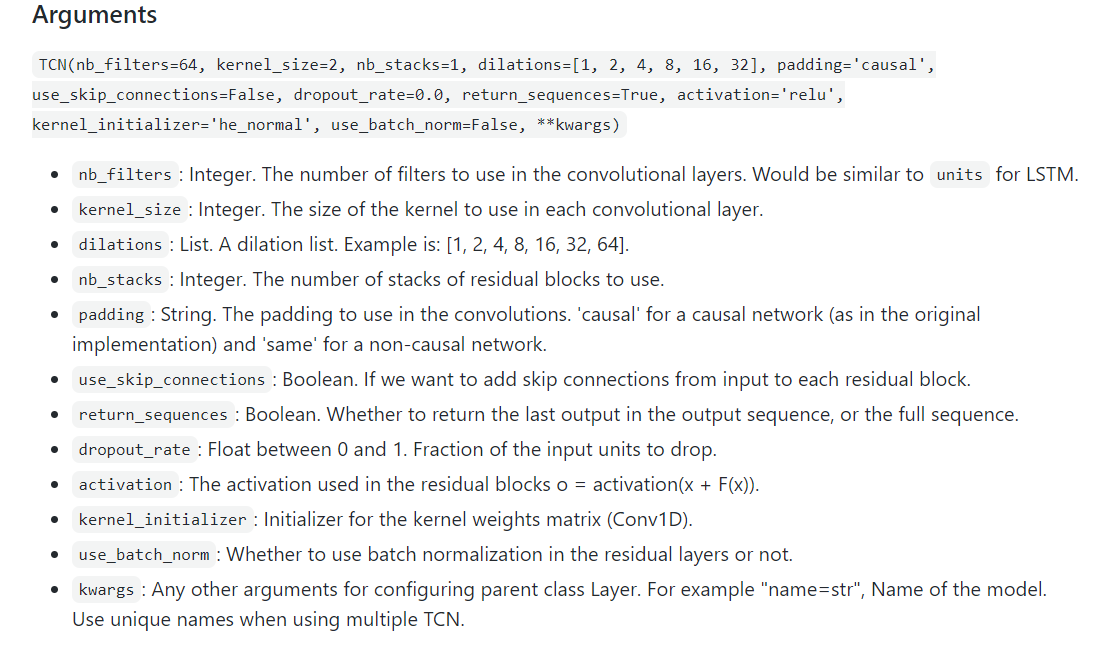

### Train-test-split



In [258]:
#Shuffle the dataset
newdf=newdf.sample(frac=1,random_state=200) #random state is a seed value 200 

series = newdf.to_numpy()
# print(series.shape)

n_features = series.shape[1]
train_split = int(series.shape[0]*0.7)
print(f'train split : {train_split}')

val_split = int(series.shape[0]*0.8)

X_train, y_train = series[:train_split, :n_features-1], series[:train_split, -1] # -1 references the last column
X_valid, y_valid = series[train_split:val_split, :n_features-1], series[train_split:val_split, -1]
X_test, y_test = series[val_split:, :n_features-1], series[val_split:, -1]
print(f'{X_train.shape,y_train.shape,X_valid.shape, y_valid.shape, X_test.shape,y_test.shape}')

train split : 2118183
((2118183, 11), (2118183,), (302598, 11), (302598,), (605196, 11), (605196,))


In [259]:
#X_train stats
newdf[:train_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,1883247,1883247,1883247,1883247,1883247,1883247,1883247,1883247,1883247,1883247,1883247
1,234936,234936,234936,234936,234936,234936,234936,234936,234936,234936,234936


In [280]:
1-(234936/1883247)

0.8752495025878178

In [260]:
#X_valid split
newdf[train_split:val_split].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,269042,269042,269042,269042,269042,269042,269042,269042,269042,269042,269042
1,33556,33556,33556,33556,33556,33556,33556,33556,33556,33556,33556


In [279]:
1 - (33556/269042)

0.8752759792151411

In [261]:
#X_test
newdf[val_split:].groupby('label').count()

,CAN ID,RTR,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8
label,,,,,,,,,,,
0,538064,538064,538064,538064,538064,538064,538064,538064,538064,538064,538064
1,67132,67132,67132,67132,67132,67132,67132,67132,67132,67132,67132


In [262]:
1 - (66685/538511)

0.876167803443198

In [263]:
testdf = pd.Series(y_test)
testdf.value_counts()

0    538064
1     67132
dtype: int64

In [264]:
 tf.keras.backend.clear_session()

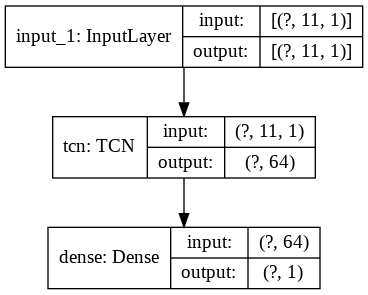

In [ ]:
tf.keras.utils.plot_model(m,show_shapes=True)

## Hyperparameters and Model Size

### Number of filters = 24

In [ ]:
tf.keras.backend.clear_session()

In [265]:
i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        nb_filters=24,
        kernel_size=2,
        nb_stacks=1,
        # dilations=[1,2,4,8],
        padding='same',
        use_skip_connections=False,
        dropout_rate=0.0,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=True)(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam',
          loss='mse',
          metrics=['accuracy'])

tcn_full_summary(m, expand_residual_blocks=True)

early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = m.fit(X_train, y_train,
      validation_data=(X_valid,y_valid),
      epochs=5,
      batch_size=128,
      callbacks=[early_stop])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 11, 24)            48        
_________________________________________________________________
activation_2 (Activation)    (None, 11, 24)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 11, 24)            72        
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 24)            96        
_________________________________________________________________
activation (Activation)      (None, 11, 24)            0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 11, 24)           

#### Evaluation and Plotting

In [266]:
scores = m.evaluate(X_test,y_test)
print(f"Loss, Accuracy: {scores}")

18913/18913 [==============================] - 68s 4ms/step - loss: 0.0422 - accuracy: 0.9395
Loss, Accuracy: [0.04219415411353111, 0.9395039081573486]


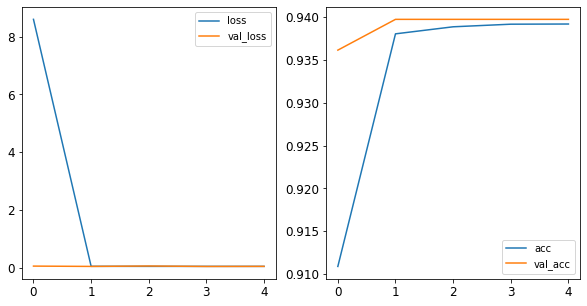

In [267]:
plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(('acc','val_acc'))

plt.gcf().set_size_inches((10,5))
plt.show()

In [268]:
y_pred = m.predict(X_test, )

In [269]:
X_test[30],y_test[30], np.argmax(y_pred[30])

(array([399,   0,   8,   0,  44,  24,   0,   0,  63,   0,   0]), 0, 0)

In [270]:
classes = np.array([np.argmax(i) for i in y_pred])
np.unique(classes), classes[:20]

(array([0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [271]:
recall_score(y_test,classes)

0.0

In [272]:
predlist = classes.reshape((classes.shape[0],1))
y_test.shape, y_pred.shape, predlist.shape

((605196,), (605196, 1), (605196, 1))

In [273]:
compdf = pd.DataFrame(predlist)
compdf['real'] = y_test
compdf = compdf.rename(columns={0:'pred'})
compdf['T/F Prediction'] = np.where(compdf['pred'] == compdf['real'],True, False)
compdf

,pred,real,T/F Prediction
0,0,0,True
1,0,0,True
2,0,0,True
3,0,1,False
4,0,0,True
...,...,...,...
605191,0,0,True
605192,0,0,True
605193,0,0,True
605194,0,0,True


In [274]:
np.unique(compdf.loc[compdf.real == 1]['T/F Prediction'])

array([False])

In [278]:
np.unique(compdf['pred'])

array([0])

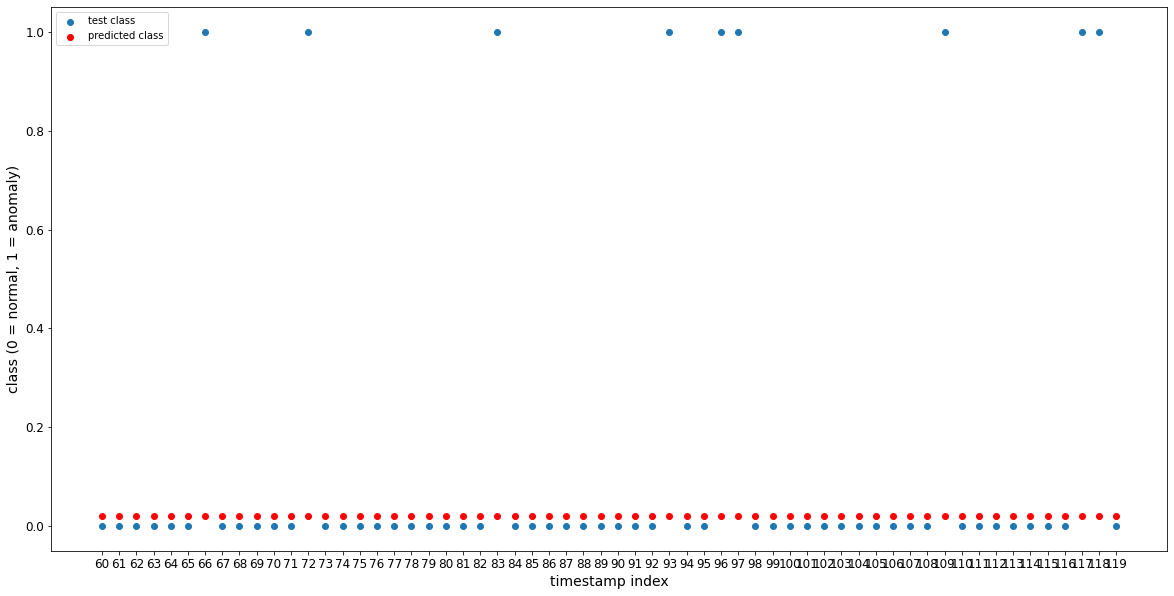

In [275]:
plot_min=60
plot_max =120
plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.02 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
plt.legend(('test class','predicted class'))
plt.xlabel('timestamp index')
plt.ylabel('class (0 = normal, 1 = anomaly)')
plt.xticks(ticks=range(plot_min, plot_max))
plt.gcf().set_size_inches((20,10))
# plt.gcf().autofmt_xdate()
plt.show()

#### Saving and Checking the size of the Model

In [276]:
saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
m.save(saved_model_dir + "tcn-24filter.h5",include_optimizer=False)
print(f"Saving Model to: {saved_model_dir}tcn-24filter.h5")

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-24filter.h5


In [277]:
print(f'Size of the model without compression: {os.path.getsize(saved_model_dir + "tcn-24filter.h5")/float(2**20)} Mb')

Size of the model without compression: 0.1211700439453125 Mb


### Number of filters = 128

In [281]:
tf.keras.backend.clear_session()

In [282]:
i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        nb_filters=128,
        kernel_size=2,
        nb_stacks=1,
        # dilations=[1,2,4,8],
        padding='same',
        use_skip_connections=False,
        dropout_rate=0.0,
        activation='relu',
        kernel_initializer='he_normal',
        use_batch_norm=True)(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam',
          loss='mse',
          metrics=['accuracy'])

tcn_full_summary(m, expand_residual_blocks=True)

early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = m.fit(X_train, y_train,
      validation_data=(X_valid,y_valid),
      epochs=5,
      batch_size=128,
      callbacks=[early_stop])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 11, 128)           256       
_________________________________________________________________
activation_2 (Activation)    (None, 11, 128)           0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 11, 128)           384       
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 128)           512       
_________________________________________________________________
activation (Activation)      (None, 11, 128)           0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 11, 128)          

#### Evaluation and Plotting

In [283]:
scores = m.evaluate(X_test,y_test)
print(f"Loss, Accuracy: {scores}")

18913/18913 [==============================] - 71s 4ms/step - loss: 0.0405 - accuracy: 0.9373
Loss, Accuracy: [0.040526796132326126, 0.9372566938400269]


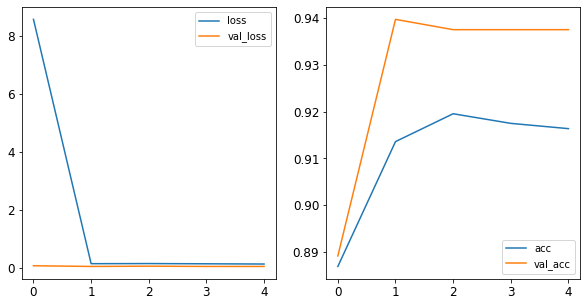

In [284]:
plt.subplot(1,2,1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(('loss','val_loss'))
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(('acc','val_acc'))

plt.gcf().set_size_inches((10,5))
plt.show()

In [285]:
y_pred = m.predict(X_test, )

In [286]:
X_test[30],y_test[30], np.argmax(y_pred[30])

(array([399,   0,   8,   0,  44,  24,   0,   0,  63,   0,   0]), 0, 0)

In [287]:
classes = np.array([np.argmax(i) for i in y_pred])
np.unique(classes), classes[:20]

(array([0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [288]:
recall_score(y_test,classes)

0.0

In [289]:
predlist = classes.reshape((classes.shape[0],1))
y_test.shape, y_pred.shape, predlist.shape

((605196,), (605196, 1), (605196, 1))

In [290]:
compdf = pd.DataFrame(predlist)
compdf['real'] = y_test
compdf = compdf.rename(columns={0:'pred'})
compdf['T/F Prediction'] = np.where(compdf['pred'] == compdf['real'],True, False)
compdf

,pred,real,T/F Prediction
0,0,0,True
1,0,0,True
2,0,0,True
3,0,1,False
4,0,0,True
...,...,...,...
605191,0,0,True
605192,0,0,True
605193,0,0,True
605194,0,0,True


In [291]:
np.unique(compdf.loc[compdf.real == 1]['T/F Prediction'])

array([False])

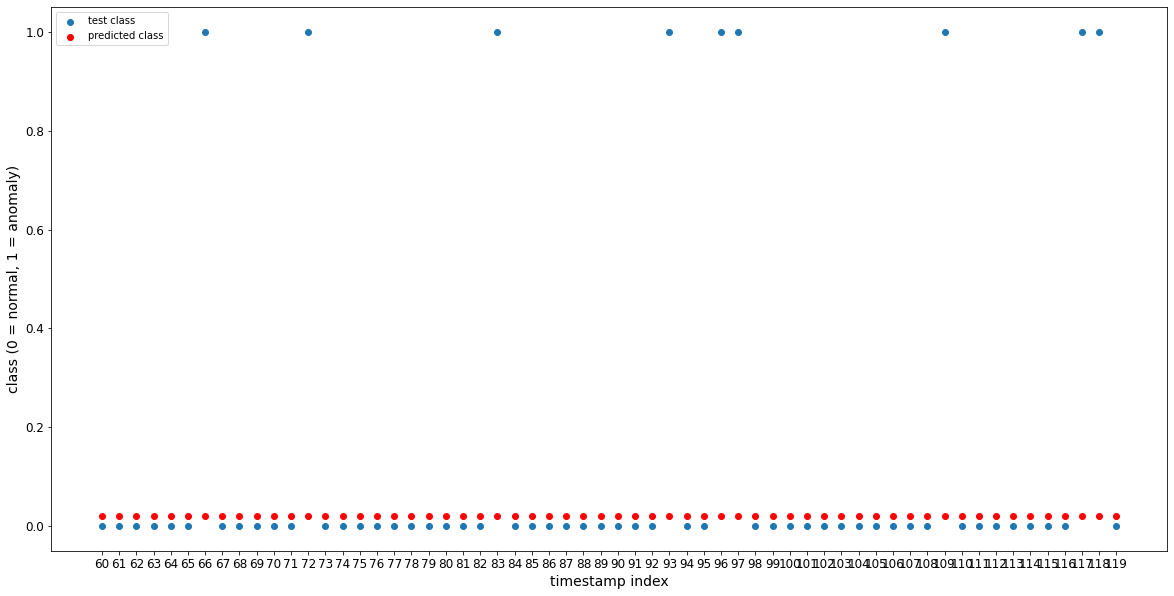

In [292]:
plot_min=60
plot_max =120
plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.02 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
plt.legend(('test class','predicted class'))
plt.xlabel('timestamp index')
plt.ylabel('class (0 = normal, 1 = anomaly)')
plt.xticks(ticks=range(plot_min, plot_max))
plt.gcf().set_size_inches((20,10))
# plt.gcf().autofmt_xdate()
plt.show()

#### Saving and Checking the size of the Model

In [293]:
saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
m.save(saved_model_dir + "tcn-128filter.h5",include_optimizer=False)
print(f"Saving Model to: {saved_model_dir}tcn-24filter.h5")

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-24filter.h5


In [294]:
print(f'Size of the model without compression: {os.path.getsize(saved_model_dir + "tcn-128filter.h5")/float(2**20)} Mb')

Size of the model without compression: 1.47320556640625 Mb


### Filters Comparison Table

| Metric\Filters | 24 | 64 | 128 |
|---|---|---|---|
|Accuracy(%)|0.9395|0.9391|0.9372|
|Size(MB)|0.1211|0.4266|1.4732|
|Total Parameters|14,233|94,273|368,769|
|Inference Time(sec)|68|10|71|

### Dropout

This is an important hyperparameter that can be used to force the model to drop details of what it's learnt and generalize better. Our baseline model worked with 0 dropout, below we introduce drop out layers between the first Conv1D layer. We vary the dropout percentage between 0.5 and 0.8. Both values are ones that have personally given us good values in our previous assignments.

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 11, 24)            48        
_________________________________________________________________
activation_2 (Activation)    (None, 11, 24)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 11, 24)            72        
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 24)            96        
_________________________________________________________________
activation (Activation)      (None, 11, 24)            0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 11, 24)           

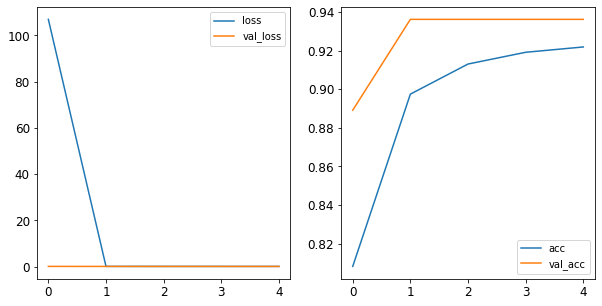

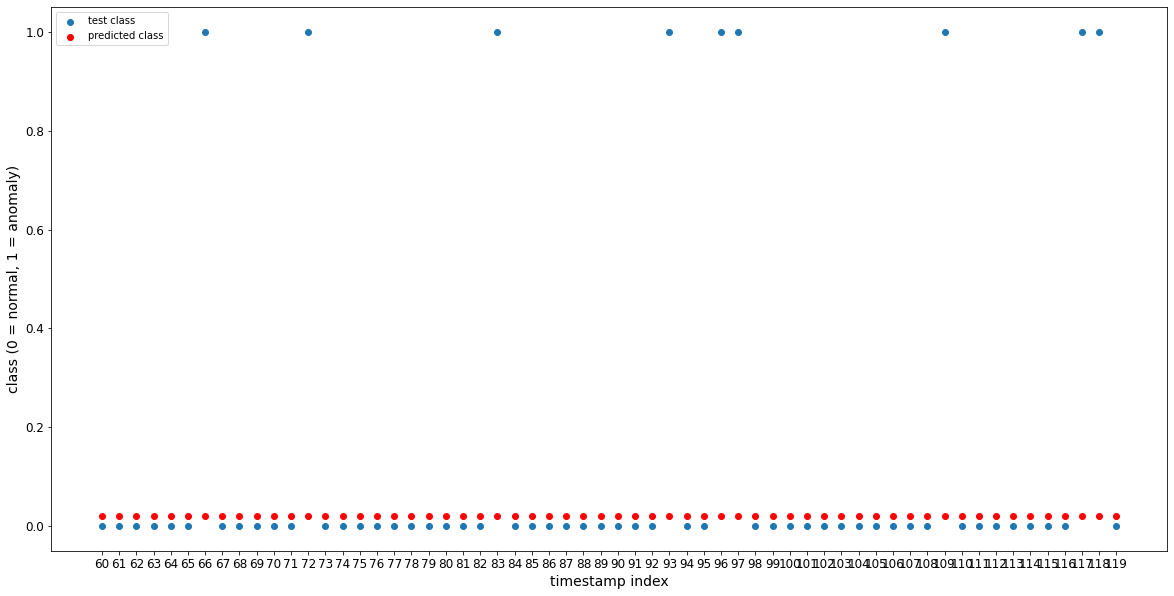

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-0.5droput.h5
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 11, 24)            48        
_________________________________________________________________
activation_2 (Activation)    (None, 11, 24)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 11, 24)            72        
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 24)            96        
_________________________________________________________________
activation (Activation)      (None, 11, 24)            0         
____________________________

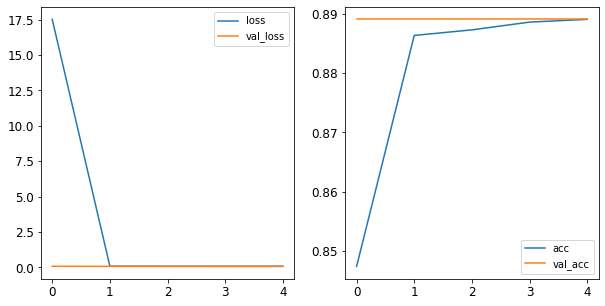

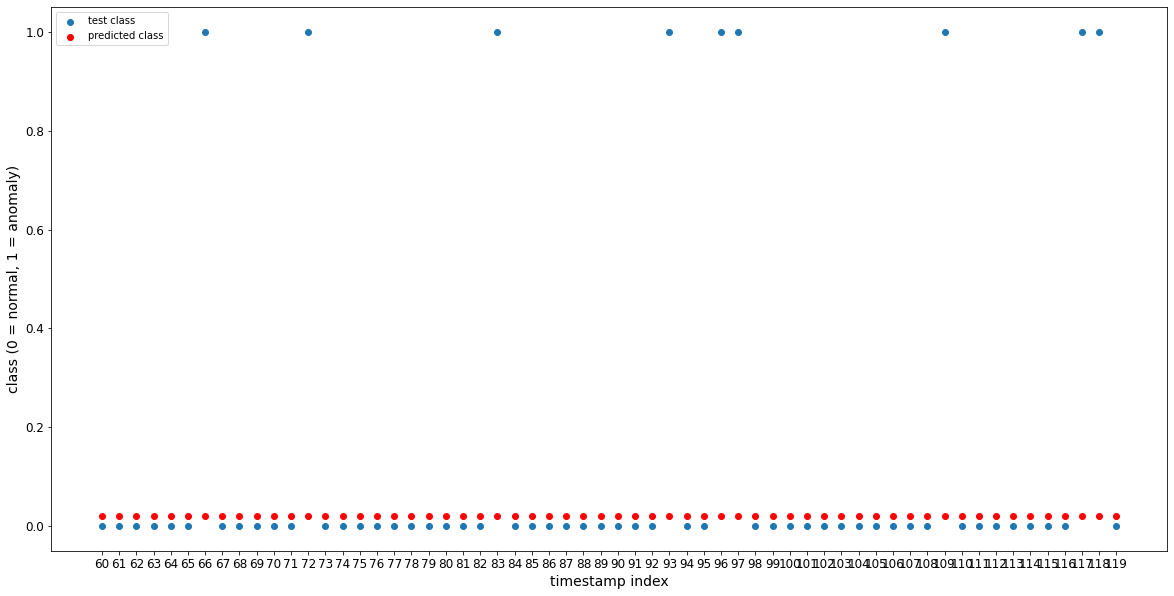

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-0.8droput.h5


<Figure size 432x288 with 0 Axes>

In [296]:
dropout_vals = [0.5,0.8]
for dropout_val in dropout_vals:
    
    tf.keras.backend.clear_session()
    ## Creating the model
    i = Input(batch_shape=(batch_size, timesteps, input_dim))

    o = TCN(return_sequences=False,
            nb_filters=24,
            kernel_size=2,
            nb_stacks=1,
            # dilations=[1,2,4,8],
            padding='same',
            use_skip_connections=False,
            dropout_rate=dropout_val,
            activation='relu',
            kernel_initializer='he_normal',
            use_batch_norm=True)(i)  # The TCN layers are here.
    o = Dense(1)(o)

    m = Model(inputs=[i], outputs=[o])
    m.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

    tcn_full_summary(m, expand_residual_blocks=True)

    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    history = m.fit(X_train, y_train,
        validation_data=(X_valid,y_valid),
        epochs=5,
        batch_size=128,
        callbacks=[early_stop])

    ## Evaluation and plotting 

    scores = m.evaluate(X_test,y_test)
    print(f"Loss, Accuracy: {scores}")

    plt.subplot(1,2,1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(('loss','val_loss'))
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.legend(('acc','val_acc'))

    plt.gcf().set_size_inches((10,5))
    plt.show()
    plt.savefig(saved_model_dir+'dropout_'+str(dropout_val)+".svg",dpi=150)

    y_pred = m.predict(X_test)

    plot_min=60
    plot_max =120
    plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
    plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.02 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
    plt.legend(('test class','predicted class'))
    plt.xlabel('timestamp index')
    plt.ylabel('class (0 = normal, 1 = anomaly)')
    plt.xticks(ticks=range(plot_min, plot_max))
    plt.gcf().set_size_inches((20,10))
    # plt.gcf().autofmt_xdate()
    plt.show()
    plt.savefig(saved_model_dir+'predict-dropout_'+str(dropout_val)+".svg",dpi=150)

    ##Saving the model and checking its size
    saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
    filename = "tcn-"+str(dropout_val)+"droput.h5"
    m.save(saved_model_dir + filename,include_optimizer=False)
    print(f"Saving Model to: {saved_model_dir+filename}")
    

In [308]:
os.path.getsize('/content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-0.5droput.h5')/float(2**20)

0.1211700439453125

In [309]:
os.path.getsize('/content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-0.8droput.h5')/float(2**20)

0.1211700439453125

### Dropout Comparison Table

| Metric\Droput | 0 | 0.5 | 0.8 |
|---|---|---|---|
|Accuracy(%)|0.9395|0.9357|0.8890|
|Size(MB)|0.1211|0.1211|0.1211|
|Total Parameters|14,233|14,233|14,233|
|Inference Time(sec)|68|66|68|

### Layers and Dilations
This hyperparameter controls the depth and skip-connections used in the Conv1D layers in the network. Our baseline uses the default, which is [1,2,4,8,16,32,64], meaning it contains 7 layers of Conv-1D, each with increasing gaps of 1,2,4 and so on between each kernel convolution step. We noticed that the default layers made our network quite complex, so we decided to drastically simplify the network to see the effect. Looking at our simple input of rows of combinations of 11-12 numeric features, we assumed a simple network to be able to learn just as well as a deep network.

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 11, 24)            48        
_________________________________________________________________
activation_2 (Activation)    (None, 11, 24)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 11, 24)            72        
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 24)            96        
_________________________________________________________________
activation (Activation)      (None, 11, 24)            0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 11, 24)           

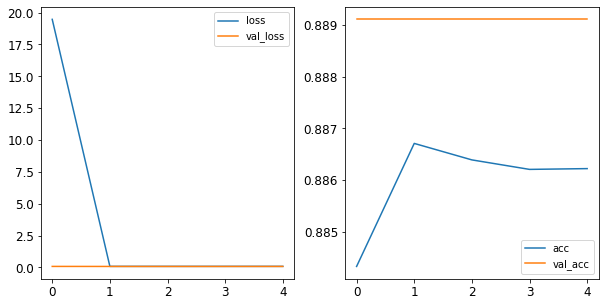

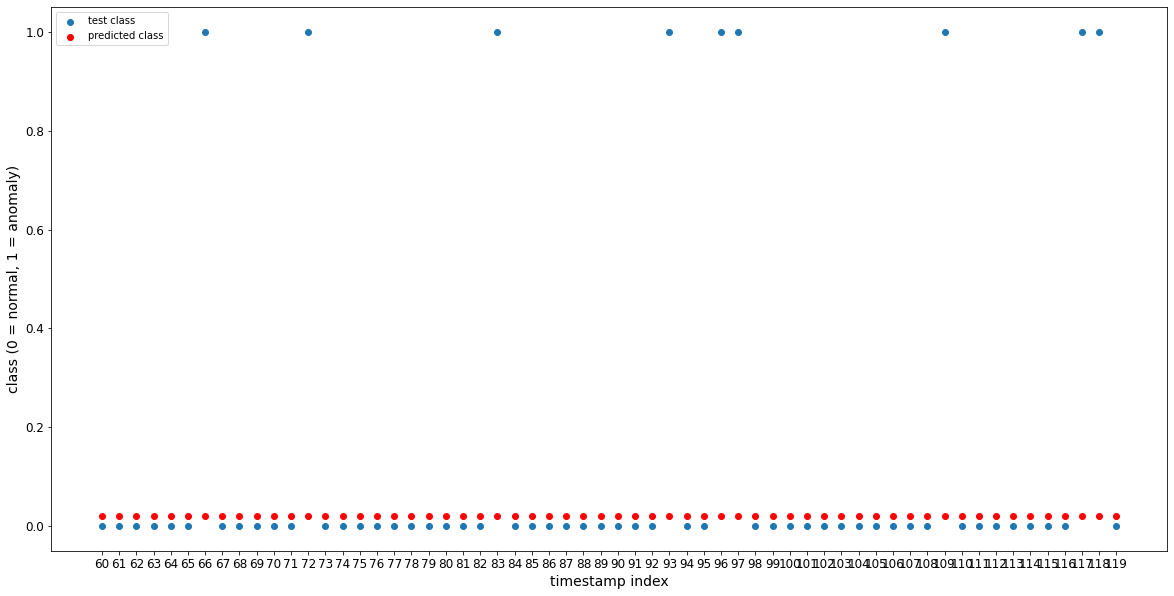

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-[1]layer.h5
Size of tcn-[1]layer.h5 is : 0.02852630615234375
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     (None, 11, 24)            48        
_________________________________________________________________
activation_2 (Activation)    (None, 11, 24)            0         
_________________________________________________________________
conv1D_0 (Conv1D)            (None, 11, 24)            72        
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 24)            96        
_________________________________________________________________
activation (Activation)      (None, 11, 24)   

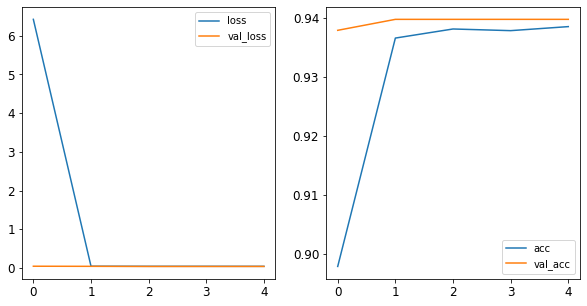

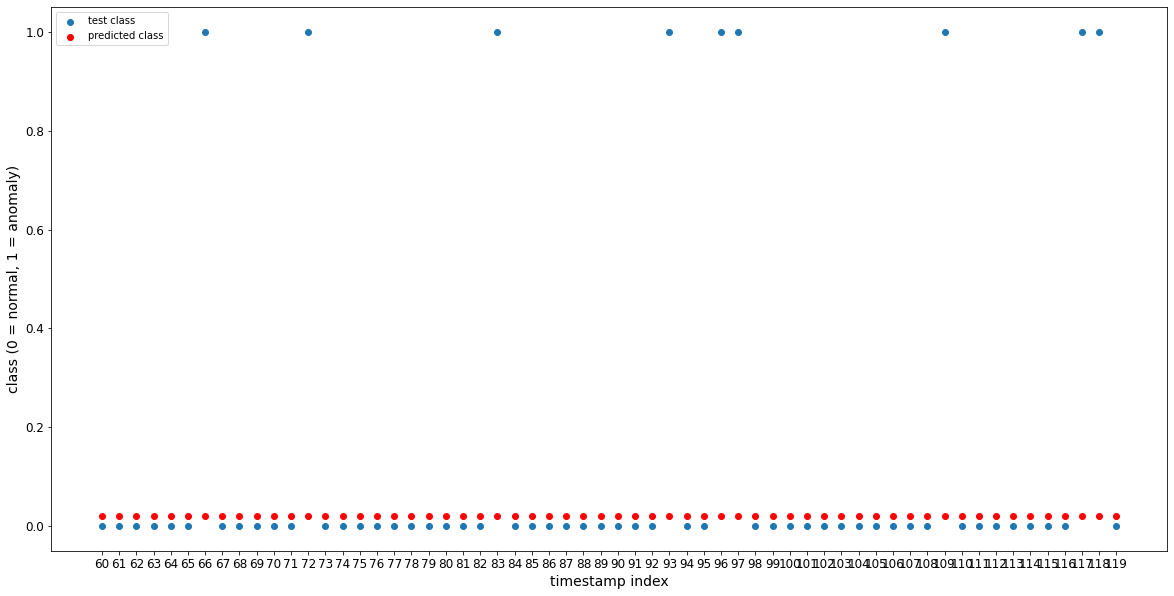

Saving Model to: /content/drive/MyDrive/Colab Notebooks/CS581/project-data/tcn-[1, 2, 4, 8]layer.h5
Size of tcn-[1, 2, 4, 8]layer.h5 is : 0.08454132080078125


<Figure size 432x288 with 0 Axes>

In [310]:
layer_vals = [[1],[1,2,4,8]]
for layer_val in layer_vals:
    
    tf.keras.backend.clear_session()
    ## Creating the model
    i = Input(batch_shape=(batch_size, timesteps, input_dim))

    o = TCN(return_sequences=False,
            nb_filters=24,
            kernel_size=2,
            nb_stacks=1,
            dilations=layer_val,
            padding='same',
            use_skip_connections=False,
            dropout_rate=0,
            activation='relu',
            kernel_initializer='he_normal',
            use_batch_norm=True)(i)  # The TCN layers are here.
    o = Dense(1)(o)

    m = Model(inputs=[i], outputs=[o])
    m.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

    tcn_full_summary(m, expand_residual_blocks=True)

    early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
    history = m.fit(X_train, y_train,
        validation_data=(X_valid,y_valid),
        epochs=5,
        batch_size=128,
        callbacks=[early_stop])

    ## Evaluation and plotting 

    scores = m.evaluate(X_test,y_test)
    print(f"Loss, Accuracy: {scores}")

    plt.subplot(1,2,1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(('loss','val_loss'))
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.legend(('acc','val_acc'))

    plt.gcf().set_size_inches((10,5))
    plt.show()
    plt.savefig(saved_model_dir+'layer_'+str(len(layer_val))+".svg",dpi=150)

    y_pred = m.predict(X_test)

    plot_min=60
    plot_max =120
    plt.scatter(range(plot_min,plot_max),y_test[plot_min:plot_max])
    plt.scatter(range(plot_min,plot_max),[y_pred[i].argmax()+0.02 for i in range(len(y_pred[plot_min:plot_max]))],c=['r'])
    plt.legend(('test class','predicted class'))
    plt.xlabel('timestamp index')
    plt.ylabel('class (0 = normal, 1 = anomaly)')
    plt.xticks(ticks=range(plot_min, plot_max))
    plt.gcf().set_size_inches((20,10))
    # plt.gcf().autofmt_xdate()
    plt.show()
    plt.savefig(saved_model_dir+'predict-layer_'+str(len(layer_val))+".svg",dpi=150)

    ##Saving the model and checking its size
    saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/CS581/project-data/'
    filename = "tcn-"+str(layer_val)+"layer.h5"
    m.save(saved_model_dir + filename,include_optimizer=False)
    print(f"Saving Model to: {saved_model_dir+filename}")
    print(f"Size of {filename} is : {os.path.getsize(saved_model_dir + filename)/float(2**20)}")
    

### Layer Dilation Comparison Table

| Metric\Layers | [1] | [1,2,4,8] | [1, 2, 4, 8, 16, 32] |
|---|---|---|---|
|Accuracy(%)|0.8890|0.9395|0.9395|
|Size(MB)|0.0285|0.0845|0.1211|
|Total Parameters|14,233|14,233|14,233|
|Inference Time(sec)|41|62|68|

# End